In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from pyspark.sql.functions import col,isnan, when, count
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg
from pyspark.sql.functions import udf
from scipy.spatial import distance

import pyspark.sql.functions as F


import pyspark

from pyspark.sql.types import FloatType
from pyspark.sql.types import BooleanType
from pyspark.sql.types import IntegerType
from pyspark.sql.types import DateType
from pyspark.sql.functions import regexp_replace
from pyspark.sql import SQLContext

from pyspark.ml.clustering import KMeans



In [2]:
sc = pyspark.SparkContext()

In [3]:
spark = SparkSession.builder \
    .master("local") \
    .appName("AppName") \
    .getOrCreate()

#data = spark.read.option("header",True).option('inferSchema', True).csv("Google-Playstore.csv", sep =',')


In [4]:
data = spark.read.option("header",True).option('inferSchema', True).json("cleaned_v3.json")

In [5]:
data = data.na.drop(subset='Reviews_Installs_Ratio')


In [6]:
data.printSchema()

root
 |-- Ad Supported: boolean (nullable = true)
 |-- Age: long (nullable = true)
 |-- App Id: string (nullable = true)
 |-- App Name: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Developer Id: string (nullable = true)
 |-- Editors Choice: boolean (nullable = true)
 |-- In App Purchases: boolean (nullable = true)
 |-- Installs: double (nullable = true)
 |-- Installs_stdev_from_Category: double (nullable = true)
 |-- Minimum Android: double (nullable = true)
 |-- Price: double (nullable = true)
 |-- Price_stdev_from_Category: double (nullable = true)
 |-- Quarter of Release: string (nullable = true)
 |-- Rating: double (nullable = true)
 |-- Rating_Reviews_Ratio: double (nullable = true)
 |-- Rating_stdev_from_Category: double (nullable = true)
 |-- Reviews_Installs_Ratio: double (nullable = true)
 |-- Size: string (nullable = true)
 |-- Size_stdev_from_Category: double (nullable = true)
 |-- Year of Last Update: string (nullable = true)
 |-- Year of Release: s

In [7]:
data = data.withColumn("Year of Last Update", data["Year of Last Update"].cast(IntegerType()).alias("Year of Last Update"))
data = data.withColumn("Year of Release", data["Year of Release"].cast(IntegerType()).alias("Year of Release"))
data = data.withColumn("Size", data["Size"].cast(FloatType()).alias("Size"))
data = data.withColumn("Reviews_Installs_Ratio", data["Reviews_Installs_Ratio"].cast(FloatType()).alias("Reviews_Installs_Ratio"))

data = data.withColumnRenamed('Ad Supported', 'AdSupported')
data = data.withColumnRenamed('App Id', 'AppId')
data = data.withColumnRenamed('App Name', 'AppName')
data = data.withColumnRenamed('Developer Id', 'DeveloperId')
data = data.withColumnRenamed('In App Purchases', 'InApp')

data = data.withColumnRenamed('Minimum Android', 'MinAndroid')
data = data.withColumnRenamed('Editors Choice', 'EditorsChoice')



In [8]:

for col in data.columns:
    newcol = '_'.join(col.split(' '))
    data = data.withColumnRenamed(col, newcol)    

In [9]:
data.dtypes

[('AdSupported', 'boolean'),
 ('Age', 'bigint'),
 ('AppId', 'string'),
 ('AppName', 'string'),
 ('Category', 'string'),
 ('DeveloperId', 'string'),
 ('EditorsChoice', 'boolean'),
 ('InApp', 'boolean'),
 ('Installs', 'double'),
 ('Installs_stdev_from_Category', 'double'),
 ('MinAndroid', 'double'),
 ('Price', 'double'),
 ('Price_stdev_from_Category', 'double'),
 ('Quarter_of_Release', 'string'),
 ('Rating', 'double'),
 ('Rating_Reviews_Ratio', 'double'),
 ('Rating_stdev_from_Category', 'double'),
 ('Reviews_Installs_Ratio', 'float'),
 ('Size', 'float'),
 ('Size_stdev_from_Category', 'double'),
 ('Year_of_Last_Update', 'int'),
 ('Year_of_Release', 'int'),
 ('nReviews', 'double'),
 ('nReviews_stdev_from_Category', 'double')]

In [10]:
features_cluster = ["Size", "Price", "Reviews_Installs_Ratio", "Rating"]



In [11]:
features_other = ["AdSupported", "Category", "DeveloperId", "EditorsChoice", "InApp",
                       "MinAndroid", "Year_of_Release", "Year_of_Last_Update", "Age"]

features_numeric = ["Rating", "Installs", "nReviews"]

In [12]:
from pyspark.ml.feature import VectorAssembler

assemble=VectorAssembler(inputCols=features_cluster, outputCol='features_cluster')

assembled_data=assemble.transform(data)

assembled_data.show(2)

+-----------+---+--------------------+--------------------+-------------+--------------------+-------------+-----+--------+----------------------------+----------+-----+-------------------------+------------------+------+--------------------+--------------------------+----------------------+----+------------------------+-------------------+---------------+--------+----------------------------+--------------------+
|AdSupported|Age|               AppId|             AppName|     Category|         DeveloperId|EditorsChoice|InApp|Installs|Installs_stdev_from_Category|MinAndroid|Price|Price_stdev_from_Category|Quarter_of_Release|Rating|Rating_Reviews_Ratio|Rating_stdev_from_Category|Reviews_Installs_Ratio|Size|Size_stdev_from_Category|Year_of_Last_Update|Year_of_Release|nReviews|nReviews_stdev_from_Category|    features_cluster|
+-----------+---+--------------------+--------------------+-------------+--------------------+-------------+-----+--------+----------------------------+----------+-

In [13]:
from pyspark.ml.feature import RobustScaler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import MaxAbsScaler



#scale=RobustScaler(inputCol='features',outputCol='standardized')
scale=MinMaxScaler(inputCol='features_cluster',outputCol='standardized')
#scale=MaxAbsScaler(inputCol='features',outputCol='standardized')



data_scale=scale.fit(assembled_data)

data_scale_output=data_scale.transform(assembled_data)

data_scale_output.show(2)

+-----------+---+--------------------+--------------------+-------------+--------------------+-------------+-----+--------+----------------------------+----------+-----+-------------------------+------------------+------+--------------------+--------------------------+----------------------+----+------------------------+-------------------+---------------+--------+----------------------------+--------------------+--------------------+
|AdSupported|Age|               AppId|             AppName|     Category|         DeveloperId|EditorsChoice|InApp|Installs|Installs_stdev_from_Category|MinAndroid|Price|Price_stdev_from_Category|Quarter_of_Release|Rating|Rating_Reviews_Ratio|Rating_stdev_from_Category|Reviews_Installs_Ratio|Size|Size_stdev_from_Category|Year_of_Last_Update|Year_of_Release|nReviews|nReviews_stdev_from_Category|    features_cluster|        standardized|
+-----------+---+--------------------+--------------------+-------------+--------------------+-------------+-----+--------

In [14]:
#NON RUNNARE!!!

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', 
                                metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,10):
    
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    
    output=KMeans_fit.transform(data_scale_output)
    
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score:",score)

Silhouette Score: 0.9602294005572355
Silhouette Score: 0.857172481246812
Silhouette Score: 0.8456499013755862
Silhouette Score: 0.82962465970725
Silhouette Score: 0.8334221282276014
Silhouette Score: 0.8003532520104596
Silhouette Score: 0.774413426047099
Silhouette Score: 0.8033461440410002


Text(0, 0.5, 'cost')

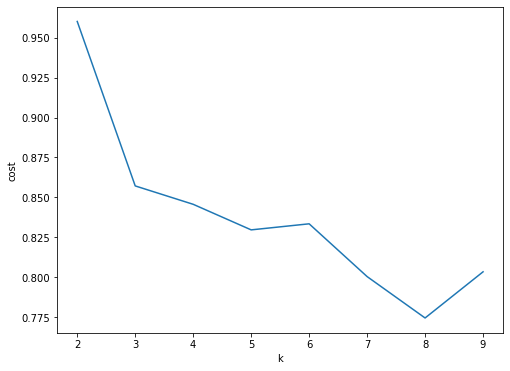

In [15]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [14]:
from pyspark.ml.clustering import KMeans

kMeans=KMeans(featuresCol='standardized', k=3, seed=42)
    
Model=kMeans.fit(data_scale_output)
    
output=Model.transform(data_scale_output)

In [15]:
dist_clusters = output.select("prediction").distinct().rdd.map(lambda x: x[0]).collect()
dd = {}
for j in dist_clusters:
    dd[j] = output.filter(output["prediction"] == j).select(features_cluster+features_other+features_numeric)

In [16]:
def basic_statistics(df):
    for i in df.dtypes:
        if(i[1] == 'int' or i[1] == 'double' or i[1] == 'float' or i[1] == 'bigint'):
            df.describe(i[0]).show(truncate=False)

for i in dist_clusters:
    print("----------- Statistiche cluster n°: " + str(i) + " --------")
    basic_statistics(dd[i].select(features_cluster))

----------- Statistiche cluster n°: 1 --------
+-------+------------------+
|summary|Size              |
+-------+------------------+
|count  |984232            |
|mean   |17.70591441628079 |
|stddev |22.308208935990944|
|min    |9.765625E-4       |
|max    |1126.4            |
+-------+------------------+

+-------+-------------------+
|summary|Price              |
+-------+-------------------+
|count  |984232             |
|mean   |0.09826538744218634|
|stddev |2.656563461257418  |
|min    |0.0                |
|max    |400.0              |
+-------+-------------------+

+-------+----------------------+
|summary|Reviews_Installs_Ratio|
+-------+----------------------+
|count  |984232                |
|mean   |1.2981162454537204E-4 |
|stddev |0.006723229304840392  |
|min    |0.0                   |
|max    |2.9                   |
+-------+----------------------+

+-------+--------------------+
|summary|Rating              |
+-------+--------------------+
|count  |984232              

In [17]:
for i in dist_clusters:
    print("----------- Info categorici cluster n°: " + str(i) + " --------")
    for j in features_other:
        dd[i].createOrReplaceTempView("tmp")
        tot_j = dd[i].select(j).count()
        query = spark.sql("SELECT "+str(j)+", count(*)/"+str(tot_j)+" * 100 FROM tmp GROUP BY "+ str(j) + ";")
        print("<<-- feature:"+ str(j))
        query.show()

----------- Info categorici cluster n°: 1 --------
<<-- feature:AdSupported
+-----------+---------------------------------------------------------------------------+
|AdSupported|((CAST(count(1) AS DOUBLE) / CAST(984232 AS DOUBLE)) * CAST(100 AS DOUBLE))|
+-----------+---------------------------------------------------------------------------+
|       true|                                                         41.558291134610535|
|      false|                                                         58.441708865389465|
+-----------+---------------------------------------------------------------------------+

<<-- feature:Category
+----------------+---------------------------------------------------------------------------+
|        Category|((CAST(count(1) AS DOUBLE) / CAST(984232 AS DOUBLE)) * CAST(100 AS DOUBLE))|
+----------------+---------------------------------------------------------------------------+
|   Music & Audio|                                                          

<<-- feature:Year_of_Release
+---------------+---------------------------------------------------------------------------+
|Year_of_Release|((CAST(count(1) AS DOUBLE) / CAST(984232 AS DOUBLE)) * CAST(100 AS DOUBLE))|
+---------------+---------------------------------------------------------------------------+
|           2018|                                                         14.828109632688227|
|           2015|                                                         2.7206999975615505|
|           2013|                                                         0.5582017247965926|
|           2014|                                                         1.1702525420835739|
|           2019|                                                         24.950621398206927|
|           2020|                                                         28.757447431093482|
|           2012|                                                         0.2585772460151672|
|           2016|              

<<-- feature:EditorsChoice
+-------------+---------------------------------------------------------------------------+
|EditorsChoice|((CAST(count(1) AS DOUBLE) / CAST(264800 AS DOUBLE)) * CAST(100 AS DOUBLE))|
+-------------+---------------------------------------------------------------------------+
|         true|                                                       0.006419939577039275|
|        false|                                                          99.99358006042296|
+-------------+---------------------------------------------------------------------------+

<<-- feature:InApp
+-----+---------------------------------------------------------------------------+
|InApp|((CAST(count(1) AS DOUBLE) / CAST(264800 AS DOUBLE)) * CAST(100 AS DOUBLE))|
+-----+---------------------------------------------------------------------------+
| true|                                                         11.003021148036254|
|false|                                                          

<<-- feature:DeveloperId
+--------------------+---------------------------------------------------------------------------+
|         DeveloperId|((CAST(count(1) AS DOUBLE) / CAST(840820 AS DOUBLE)) * CAST(100 AS DOUBLE))|
+--------------------+---------------------------------------------------------------------------+
|  Professional amera|                                                       4.757260769249066...|
|           Arab Unit|                                                       0.006303370519255012|
|Proven Digital We...|                                                       0.003449014057705573|
|   Rubega Developers|                                                         3.5679455769368E-4|
|            Point.56|                                                       2.378630384624533...|
|      Rigolas Studio|                                                        0.00392474013463048|
|           Netcandle|                                                       2.37863

<<-- feature:Age
+---+---------------------------------------------------------------------------+
|Age|((CAST(count(1) AS DOUBLE) / CAST(840820 AS DOUBLE)) * CAST(100 AS DOUBLE))|
+---+---------------------------------------------------------------------------+
|  0|                                                          90.63616469636783|
|  2|                                                          9.355629028805215|
| -1|                                                        0.00820627482695464|
+---+---------------------------------------------------------------------------+



In [18]:
for i in dist_clusters:
    print("----------- Statistiche cluster n°: " + str(i) + " --------")
    basic_statistics(dd[i].select(features_numeric))

----------- Statistiche cluster n°: 1 --------
+-------+--------------------+
|summary|Rating              |
+-------+--------------------+
|count  |984232              |
|mean   |0.005028590820050552|
|stddev |0.08153024836791624 |
|min    |0.0                 |
|max    |1.5                 |
+-------+--------------------+

+-------+-----------------+
|summary|Installs         |
+-------+-----------------+
|count  |984232           |
|mean   |727.5897146201302|
|stddev |57719.97830085847|
|min    |1.0              |
|max    |5.0E7            |
+-------+-----------------+

+-------+------------------+
|summary|nReviews          |
+-------+------------------+
|count  |984232            |
|mean   |1.2765425224946965|
|stddev |284.65623681134036|
|min    |0.0               |
|max    |233963.0          |
+-------+------------------+

----------- Statistiche cluster n°: 2 --------
+-------+------------------+
|summary|Rating            |
+-------+------------------+
|count  |264800         

In [19]:
#dist = udf(lambda standardized, prediction: standardized - centers[prediction])
#output = output.withColumn('dist', dist(output.standardized, output.prediction))


In [20]:
centers = Model.clusterCenters()

distance_udf = F.udf(lambda x, y: float(distance.euclidean(x, centers[y])), FloatType())
df = output.withColumn('distances', distance_udf(F.col('standardized'), F.col('prediction')))

In [ ]:
df = df.sort('distances', ascending=True)

In [ ]:
from pyspark.sql.functions import monotonically_increasing_id 

df = df.select("*").withColumn("position", monotonically_increasing_id())

In [23]:
inlier = int(df.count()) - int(0.01 * df.count()) 

#da questo valore in sù sono inlier, perché il df è in ordine ascendente di distanza
#prima i "più inlier", poi quelli "sempre più outlier"
#diminuendo la soglia di outlier prevista (0.001), aumentiamo il numero di inlier




In [24]:
df_final = df.filter(df.position > inlier)

In [ ]:
#df_final.count()

In [25]:
df_final.repartition(1).write.json("df_no_outlier_KMeans_v3.json")

In [ ]:
import pandas as pd

df = pd.read_json("no_outlier_KMeans_v3.json", lines=True)

len(df)

In [ ]:
block